In [266]:
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
from collections import deque

def fifo(cache, item, m):
    hit = item in cache
    if not hit:
        cache.popleft() # pop front (oldes) item
        cache.append(item) # add new item to the back
    return hit

def rand(cache, item, m):
    hit = item in cache
    if not hit:
        ind = random.randint(0, m - 1) # randomise item for eviction
        cache[ind] = item # replace the item
    return hit
        
def poisson(l):
    return -np.log(random.random()) / l
        
def run_simulation(m, n, policy, duration, batches, warmup):
    
    # some of these are initialised for performance boost
    # f.e. cache_range so that we don't need to recalculate
    # for every batch
    cache_range = range(m)
    cache = deque([i for i in cache_range])
    ls = [1 / i for i in range(1, n + 1)]
    arrivals = [0 for l in ls]
    end = duration + warmup
    out = []
    n_range = range(n)
    
    for i in range(batches):
        
        res = []
        # instead of creating a new arrays we can just reuse the ones
        # we calculated before. We can also reuse the 
        for j in n_range:
            arrivals[j] = poisson(ls[j])
        for j in cache_range:
            cache[j] = j
            
        hits = 0
        queries = 0
        curr = 0
        counter = 0
        while(curr < end):
            ind = np.argmin(arrivals) # get the index next arrival
            curr = arrivals[ind] # set the curr time to the next arrival
            hit = policy(cache, ind, m) # simulate cach query
            arrivals[ind] = poisson(ls[ind]) + curr # schedule the next arrival
            if hit:
                hits += 1
            queries += 1
            if (curr >= warmup):
                res.append(hits / queries)
        out.append(res)
    return out

def get_ci(x, alpha=0.025):
    """
    Calculates confidence interval
    
    Parameters:
    x [float]: data points
    alpha (float): the confidence measure
    """
    batches = len(x)
    x_bar = np.mean(x) # average
    s = np.std(x, ddof=1) / np.sqrt(batches) # sample variance
    if batches >= 40:
        t = stats.norm.ppf(1 - alpha) # if dataset is big enough use normal distribution
    else:
        t = stats.t.ppf(1 - alpha,df=batches - 1) # otherwise use T distribution
    d = t * s / np.sqrt(batches)
    return [x_bar - d, x_bar, x_bar + d]


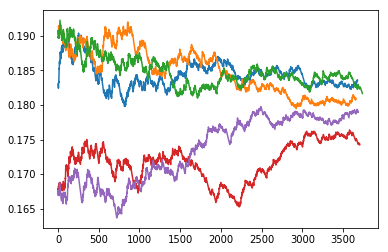

hit ratio: [0.177936885701753, 0.17990637119634564, 0.18187585669093828]
miss rate: [6.124044435052694, 6.138786961332744, 6.1535294876127935]
point estimates: [0.18357487922705315, 0.1809672386895476, 0.18166123153654326, 0.17425252332888974, 0.17907598319969453]


In [267]:
m = 10
n = 1000
sim_time = 500
batches = 5
warmup = 200
res = run_simulation(m, n, fifo, sim_time, batches, warmup)
sig = sum([1 / (i + 1) for i in range(n)])
for r in res:
    plt.plot(r)
plt.show()
x = [r[-1] for r in res]
print("hit ratio: {}".format(get_ci(x)))
print("miss rate: {}".format(get_ci([(1 - x_i) * sig for x_i in x])))
print("point estimates: {}".format(x))

In [268]:
m = 2
n = 3
ls = [1 / (i + 1) for i in range(n)] # lambdas
sig = sum(ls) # number of arrivals per second
ps = [0] + [1 / ((i + 1) * sig) for i in range(n)] # probability that i will arrive next is ps[i]

In [269]:
# Generate all possible states for rand policy with (1, 2) initial state.
# i.e. all pairs of the form (i, j) s.t. i != j and i, j <- {1, 2, 3}
S_rand = []
for i in range(1, n + 1):
    for j in range(i + 1, n + 1):
        S_rand.extend([(i, j), (j, i)])

# Generate the generator matrix
Q_rand = [[0 for _ in S_rand] for _ in S_rand]
for i, s1 in enumerate(S_rand):
    for j, s2 in enumerate(S_rand):
        # (i, j) -> (k, l) is possible only if i == k or j == l
        # but also one of the elements needs to change
        if s1[0] == s2[0] and s1[1] != s2[1]:
            Q_rand[i][j] = 1 / m * ps[s2[1]] # 1 / m is the probability of evicting a particular cell
                                             # and ps[s2[1]] is the probability of arrival of that item
        elif s1[0] != s2[0] and s1[1] == s2[1]:
            Q_rand[i][j] = 1 / m * ps[s2[0]]
for i, r in enumerate(Q):
    Q_rand[i][i] = -sum(r)
print("Generator matrix: ")
print(np.array(Q_rand))
for i in Q_rand:
    i[-1] = 1
print("Augmented generator matrix: ")
print(np.array(Q_rand))

Generator matrix: 
[[-0.90909091  0.          0.09090909  0.          0.          0.09090909]
 [ 0.         -1.          0.          0.09090909  0.09090909  0.        ]
 [ 0.13636364  0.         -1.          0.          0.13636364  0.        ]
 [ 0.          0.13636364  0.         -0.86363636  0.          0.13636364]
 [ 0.          0.27272727  0.27272727  0.         -1.          0.        ]
 [ 0.27272727  0.          0.          0.27272727  0.         -1.54545455]]
Augmented generator matrix: 
[[-0.90909091  0.          0.09090909  0.          0.          1.        ]
 [ 0.         -1.          0.          0.09090909  0.09090909  1.        ]
 [ 0.13636364  0.         -1.          0.          0.13636364  1.        ]
 [ 0.          0.13636364  0.         -0.86363636  0.          1.        ]
 [ 0.          0.27272727  0.27272727  0.         -1.          1.        ]
 [ 0.27272727  0.          0.          0.27272727  0.          1.        ]]


[(1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2)]


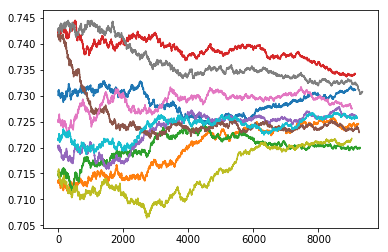

expected hit ratio: 0.7272727272727273
hit ratio: [0.7254098134182972, 0.7264295230077719, 0.7274492325972465]
miss rate: [0.49967640690504833, 0.5015458744857517, 0.5034153420664551]
point estimates: [0.731114756659636, 0.7244953627932351, 0.7199720127497473, 0.7342184952247846, 0.7259622876733676, 0.7229213309657995, 0.7274312435602758, 0.7307544116513832, 0.7217357001972386, 0.72568962860225]


In [270]:
p_rand = [1 / 4, 1 / 4, 1 / 6, 1 / 6, 1 / 12, 1 / 12] #Solution to global equilibrium equations
hit_ratio_rand = 0
print(S_rand)
for i, s in enumerate(S_rand):
    hit_ratio_rand += (ps[s[0]] + ps[s[1]]) * p_rand[i]
res = run_simulation(2, 3, rand, 5000, 10, 2000)
for r in res:
    plt.plot(r)
plt.show()
print("expected hit ratio: {}".format(hit_ratio_rand))
x = [r[-1] for r in res]
print("hit ratio: {}".format(get_ci(x)))
print("miss rate: {}".format(get_ci([(1 - x_i) * sig for x_i in x])))
print("point estimates: {}".format(x))

In [271]:
S_fifo = [(1, 2), (2, 3), (3, 1)] # These are the only reachable states given (1, 2) is the initial one

# On the assumption that m = 2, and n = 3, generate the generator matrix
Q_fifo = [[0 for _ in S_fifo] for _ in S_fifo]
for i, s1 in enumerate(S_fifo):
    for j, s2 in enumerate(S_fifo):
        if s1[1] == s2[0]: # s2[1] is coming in to cache and s1[1] is evicted
            Q_fifo[i][j] = ps[s2[1]] # the probability of this state transition is precisely
                                     # the probability of hitting s2[1]
for i, r in enumerate(Q_fifo):
    Q_fifo[i][i] = -sum(r)
    
print("Generator matrix: ")
print(np.array(Q_fifo))
for i in Q_fifo:
    i[-1] = 1
print("Augmented generator matrix: ")
print(np.array(Q_fifo))

Generator matrix: 
[[-0.18181818  0.18181818  0.        ]
 [ 0.         -0.54545455  0.54545455]
 [ 0.27272727  0.         -0.27272727]]
Augmented generator matrix: 
[[-0.18181818  0.18181818  1.        ]
 [ 0.         -0.54545455  1.        ]
 [ 0.27272727  0.          1.        ]]


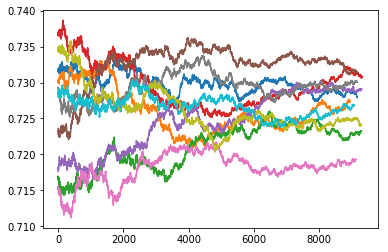

expected hit ratio: 0.7272727272727273
hit ratio: [0.7261488576044927, 0.7270091897655349, 0.7278695219265771]
miss rate: [0.4989058764679421, 0.5004831520965195, 0.5020604277250968]
point estimates: [0.7279239993770441, 0.7273881307521421, 0.7232301397359685, 0.7307811052794072, 0.7290897908979089, 0.7313559978316425, 0.7192818838890184, 0.7301118707271598, 0.724169741697417, 0.7267592374676395]


In [273]:
p_fifo = [1 / 2, 1 / 6, 1 / 3] # manually calculated
hit_ratio_fifo = 0
for i, s in enumerate(S_fifo):
    hit_ratio_fifo += (ps[s[0]] + ps[s[1]]) * p_fifo[i]
res = run_simulation(2, 3, fifo, 5000, 10, 2000)
for r in res:
    plt.plot(r)
plt.show()
print("expected hit ratio: {}".format(hit_ratio_fifo))
x = [r[-1] for r in res]
print("hit ratio: {}".format(get_ci(x)))
print("miss rate: {}".format(get_ci([(1 - x_i) * sig for x_i in x])))
print("point estimates: {}".format(x))